# **Введение**

Поскольку индустрия игр очень закрыта - данные о продажах компаний являются зачастую тайной, поэтому, не стоит удивляться количеству пропусков в датасетах. Эти данные продаются на более продинутых сайтах, но это стоит достаточно приличную сумму денег, поэтому использовалось, что имелось. 

Гипотезы:

1) VGChatz подходит для анализа только старых игр, Стим перехватил на себя роль хранилища игровой информации
2) Самая популярная консоль по данным с WGChartz будет PC
3) Между ценой игры в стиме и числом покупателей этой игры существует обратная связь

Далее по тексту будут делаться другие выводы, основанные на визуальной интерпретации графиков, но не вынесенные в эту графу. 

# **Предустановка библиотек**

In [ ]:
%pip install selenium
%pip install undetected-chromedriver
%pip install requests
%pip install bs4
%pip install lxml
%pip install Jinja2
%pip install networkx
%pip install seaborn

# **Импорт всех необходимых библиотек**

In [322]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import undetected_chromedriver as uc
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nt
import seaborn as sea

# **Настройка веб-браузера и скрапинга**



Поскольку чистый webdriver разпознается браузером автоматически, мы устанавливает расширение uc, которое скрывает нашу активность. В нем есть возможность использовать прокси, но, к счастью, это не потреболось. Далее мы используем обычный функционал Селениума, чтобы скрэпить данные с сайта WGChartz, это было достаточно сложно, так как, к сожалению, не все данные находились на главной странице-ссылке. Поэтому, чтобы получить доступ к внутренней информации, мы вынуждены скрэпить дополнительно ссылки на игры, а потом каждую ссылку перебирать. Этот процесс был очень долгим, по моим подсчетам для скрэпинга 1300 страниц с 50 играми потребовалось бы не менее 12 часов, поэтому я нашел файл старого года производства и скрэпил только нововышедшие игры - 2024, 2023, 2022. Проверить работу скрипта можно, установив значение страницы на желаемом вам уровне. Данные мы переводим в csv формат.

Стоит заметить, что код, закоменченный мною, это код, которым можно заменить часть, где я использую request и BS, так как получилось, что этот
вариант работает быстрее. Но и закомменченный код яляется рабочим.

In [ ]:
page = 3

In [ ]:
### FROM https://codeby.net/threads/metody-obxoda-zaschity-ot-avtomatizirovannogo-po-v-brauzere-chrome-pod-upravleniem-selenium-v-python.81358/?ysclid=lx391cvlhz58956320

optio = Options()
optio.add_argument("--headless")
driver = uc.Chrome(options= optio)
url = f"https://www.vgchartz.com/games/games.php?page={page}"
url_plus = '&order=ReleaseDate&ownership=Both&showtotalsales=1&shownasales=1&showpalsales=1&showjapansales=1&showothersales=1&showpublisher=1&showdeveloper=0&showreleasedate=1&showlastupdate=0&showvgchartzscore=0&showcriticscore=1&showuserscore=1&showshipped=1'

### END FROM

game_links = []
game = []
console = []
publisher = []
critic_score = []
user_score = []
copies_sold = []
total_sales = []
na_sales = []
eu_sales = []
jp_sales = []
other_sales = []
year = []
genre = []

for i in range(1, page + 1):
    url = f"https://www.vgchartz.com/games/games.php?page={i}"
    url_plus = '&order=ReleaseDate&ownership=Both&showtotalsales=1&shownasales=1&showpalsales=1&showjapansales=1&showothersales=1&showpublisher=1&showdeveloper=0&showreleasedate=1&showlastupdate=0&showvgchartzscore=0&showcriticscore=1&showuserscore=1&showshipped=1'
    driver.get(url+url_plus)
    while driver.execute_script("return document.readyState") != "complete":
        pass
    bunch = driver.find_element(By.ID, 'generalBody')
    game_links += [str(x.get_attribute("href")) for x in driver.find_elements(By.TAG_NAME, 'a') if str(x.get_attribute("href")).startswith("https://www.vgchartz.com/game/")]
    console += [x.get_attribute('alt') for x in bunch.find_elements(By.CSS_SELECTOR, 'img') if x.get_attribute("alt") != "Boxart Missing"]
    data_table = bunch.find_elements(By.CSS_SELECTOR, 'td')
    lis = [x.text for x in data_table]
    game += lis[2::14]
    publisher += lis[4::14]
    critic_score += [float(x) if x != "N/A" else np.nan for x in lis[5::14]]
    user_score += [float(x) if x != "N/A" else np.nan for x in lis[6::14]]
    copies_sold += [float(x[:-1]) if x != "N/A" else np.nan for x in lis[7::14]]
    total_sales += [float(x[:-1]) if x != "N/A" else np.nan for x in lis[8::14]]
    na_sales += [float(x[:-1]) if x != "N/A" else np.nan for x in lis[9::14]]
    eu_sales += [float(x[:-1]) if x != "N/A" else np.nan for x in lis[10::14]]
    jp_sales += [float(x[:-1]) if x != "N/A" else np.nan for x in lis[11::14]]
    other_sales += [float(x[:-1]) if x != "N/A" else np.nan for x in lis[12::14]]
    year += [x for x in lis[13::14]]
driver.quit()




for item in game_links:
    site = urllib.request.urlopen(item).read()
    soup = BeautifulSoup(site, 'lxml')
    tags = soup.find("div", {"id": "gameGenInfoBox"}).find_all('h2')
    for tag in tags:
        if str(tag.text) == "Genre":
            gen = tag.find_next_sibling().text
            genre.append(gen)
        else:
            continue


#opt = Options()
#opt.add_argument("--headless")
#driver1 = webdriver.Chrome(options= opt)
#for item in game_links:
#    driver1.get(item)
#    box = driver1.find_element(By.ID, 'gameGenInfoBox')
#    box_items = box.find_elements(By.CSS_SELECTOR, 'p')
#    genre.append(box_items[1].text)
#driver.quit()


print(game_links, 
genre,
game,
console,
publisher,
critic_score,
user_score,
copies_sold,
total_sales,
na_sales,
eu_sales,
jp_sales,
other_sales,
year, sep="\n")

# **Формирование датасета и csv файла**

Как уже сообщалось, итогом скрапинга служит файл разрешения csv, заметим, что обработку данных мы провели во время процесса скрэпинга, приведя данные в нужный нам формат. 

In [ ]:
for i in range(0, len(year)):
    if year[i] == "N/A":
        year[i] = np.nan
    else:
        if int(year[i][-2:]) <= 40:
            year[i] = int("20" + year[i][-2:])
        else:
            year[i] = int("19" + year[i][-2:])

columns = {
    'Game': game,
    'Console': console,
    'Publisher': publisher,
    'Genre': genre,
    'Critic_Score': critic_score,
    'User_Score': user_score,
    'Copies': copies_sold,
    'NA_Sales': na_sales,
    'EU_Sales': eu_sales,
    'JP_Sales': jp_sales,
    'Other_Sales': other_sales,
    'Total_Sales': total_sales,
    'Year': year
}

df = pd.DataFrame(columns)
print(df)
df.to_csv("scraped_data.csv", sep=",", encoding='utf-8', index=False)

# **Подготовка необходимых датасетов**

Я нащел на сайте https://www.kaggle.com/datasets/gsimonx37/vgchartz, старые данные по VGChartz и в отдельном проекте их соединил. Я не включил этот процесс в этот проект, так как действия заключались лишь в перестановке колонок, их переименовывании, склеивании снизу и форматировании скачанного датасета тем же образом, что и я делал выше. 

Датасет Steam был получен скрэпингом, с использованием API и включал в себя более 70000 игр, поэтому мной было принято решение просто скачать его и адаптировать под свои нужды. 

Форматирование найденных датасетов

In [ ]:
#FROM https://www.iditect.com/faq/python/pandas-how-to-read-csv-file-from-google-drive-public.html?ysclid=lx6jj2jt2u266324099

url1 = 'https://drive.google.com/file/d/1XgMbAYTQy-dmvxqsW1joTJ6bYtvenHpE/view?usp=drive_link'
url1_id = url1.split("/")[5]
urlf1 = f"https://drive.google.com/uc?id={url1_id}"
data_1 = pd.read_csv(urlf1)


# END FROM

data_1["Supported languages"] = [x.rstrip("']").lstrip("['").split("', '") if (len(str(x)) >= 5) else np.nan for x in data_1["Supported languages"]]
data_1

Мы должны взглянуть на датасет подробнее. Поскольку пропусков в графе Year относительно немного, мы можем избавиться от этих строчек. Остальные пропуски не представляется возможности закрыть, так как их очень много, и мы не можем предсказать хоть с какой-то точностью. Поскольку я совмещал данные, мы избавились от всех возможных дубликатов. Посмотрев на датасеты с помощью встроенных возможностей среды - кликнув на все переменные и выбрав датасеты, отсортировав, я увидел, что выбросов как таковых нет, у некоторых игр очень высокие продажи, что нормально для данной индустрии.

In [309]:
url2 = 'https://drive.google.com/file/d/1uMapnr_HBLYSl50xTyQ6PefkQ4oEVUQ8/view?usp=drive_link'
url2_id = url2.split("/")[5]
urlf2 = f"https://drive.google.com/uc?id={url2_id}"
data_2 = pd.read_csv(urlf2)

data_2 = data_2.drop_duplicates(subset= ['Game', 'Year'])
print(data_2.isna().sum())
data_2['User_Score'].value_counts()
data_2.dropna(subset = ['Year'], inplace = True)

Game                0
Total_Sales     33457
Copies          42870
Publisher           0
Year             3421
Console             0
JP_Sales        41137
NA_Sales        38651
Other_Sales     36805
EU_Sales        38501
User_Score      46327
Critic_Score    42390
dtype: int64


# **Построение графических материалов для Steam**

Стим - достаточно молодая платформа, поэтому можно ожидать, что в начале ее зарождения, на ней не было предсавлено достаточно много старых, но мало кому известных игр. Поэтому можно было ожидать, что количество релизов игр в стим будет небольшим в дальней перспективе. Однако по графику можно сделать более любопытный вывод:

Пик релизов игр находится в 2022 году, и мы можем объянить это тем, что за время ковидных ограничений, появилось огромное число инди-разработчиков, которые решались поробовать себя в производстве игр. Именно это с большой вероятностью привело к такому стремительному росту в ковидный перио. 

Text(0, 0.5, 'Количество игр')

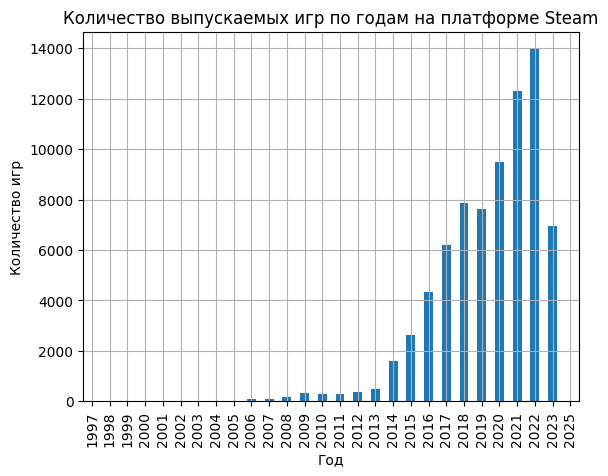

In [318]:
year_count = data_1.groupby('Release date')['Release date'].agg('count')
graph_1 = year_count.plot(title= "Количество выпускаемых игр по годам на платформе Steam", kind= "bar", grid= True)
plt.xlabel('Год')
plt.ylabel('Количество игр')

Создадим корреляционную матрицу на основе полученных данных. Отдельно стоит отметить, что мы добавили новую колонку к датасету, представляюшую собой сумму, которая описывает мультиоперационность игры, ее совместимость с различными ОС. По данным мы видим, что все игры, выложенные в Стиме, совместимы, с Windows - основная платформа для игровых актиснотей. Нашей гипотезой было то, что чем больше игра адаптирована к разным платформам, тем больше она должна стоить, так как разработка кода для Линукса и Мака достаточно сложная задача. Однако наша гипотеза не подтвердилась, коэффициент корреляции близок к нулю. 

In [219]:
data_1_temp = data_1
data_1_temp["system_sum"] = data_1["Windows"] + data_1["Mac"] + data_1["Linux"]
corr_1 = data_1_temp.iloc[:, [2,3,4,9,10,11,12,13]].corr()
corr_1.style.background_gradient(cmap='RdYlGn')

,Release date,Estimated owners,Price,Positive,Negative,Recommendations,Average playtime forever,system_sum
Release date,1.000000,-0.113035,-0.023543,-0.054340,-0.037885,-0.054339,-0.082182,-0.192623
Estimated owners,-0.113035,1.000000,0.040631,0.668665,0.642202,0.536811,0.234382,0.047410
Price,-0.023543,0.040631,1.000000,0.033905,0.027924,0.049506,0.073531,0.021188
Positive,-0.054340,0.668665,0.033905,1.000000,0.784565,0.896506,0.205189,0.030919
Negative,-0.037885,0.642202,0.027924,0.784565,1.000000,0.793219,0.194797,0.013352
Recommendations,-0.054339,0.536811,0.049506,0.896506,0.793219,1.000000,0.183409,0.026744
Average playtime forever,-0.082182,0.234382,0.073531,0.205189,0.194797,0.183409,1.000000,0.029057
system_sum,-0.192623,0.047410,0.021188,0.030919,0.013352,0.026744,0.029057,1.000000


Никакой значимой зависимости на данных, кроме очевидной, мной не было замечено. Это может быть связано с тем, что мы рассматриваем огромный пласт инди-игр, которые портят статистику, поэтому огранчим данные числом тех, кто игру получил и проведем те же манипуляции (рассматриваем только очень популярные игры).

In [223]:
corr_1_1 = data_1_temp[data_1_temp["Estimated owners"] > 35000000].iloc[:, [2,3,4,9,10,11,12,13]].corr()
corr_1_1.style.background_gradient(cmap='RdYlGn')

,Release date,Estimated owners,Price,Positive,Negative,Recommendations,Average playtime forever,system_sum
Release date,1.000000,-0.105644,0.739510,-0.301517,0.117647,-0.024462,-0.182779,-0.862582
Estimated owners,-0.105644,1.000000,-0.250000,-0.099782,-0.168954,-0.390341,0.687232,0.408248
Price,0.739510,-0.250000,1.000000,-0.431432,-0.492496,-0.322075,-0.608306,-0.612372
Positive,-0.301517,-0.099782,-0.431432,1.000000,0.581866,0.891383,0.566220,0.499781
Negative,0.117647,-0.168954,-0.492496,0.581866,1.000000,0.810460,0.524742,-0.154405
Recommendations,-0.024462,-0.390341,-0.322075,0.891383,0.810460,1.000000,0.385544,0.091822
Average playtime forever,-0.182779,0.687232,-0.608306,0.566220,0.524742,0.385544,1.000000,0.476342
system_sum,-0.862582,0.408248,-0.612372,0.499781,-0.154405,0.091822,0.476342,1.000000


Мною были замечены следующие закономерности:

1) Чем больше дата релиза, тем выше цены. Это можно объяснить инфляцией, а также тем, что популярные игровые произодители затрачивают большие объемы средств на разработку более реалистичной графики и прочего.

2) Чем больше дата релиза, тем меньше мультиоперационность. Это можно объяснить огромным наплывом инди-игр, которые зачастую разработываются только для ОС Windows. 

3) Чем больше цена, тем меньше среднее время игры. Это тоже объясняется достаточно просто. В Стиме можно вернуть деньги за игру, если проиграл в нее меньше установленного времени, поэтому многие люди просто бросают игры на этом временном промежутке, чтобы не тратить большие средства. 

Рассмотрим игры с самым высоким количеством позитивных оценок: 

In [226]:
corr_1_2 = data_1_temp[data_1_temp["Positive"] >= 70000].iloc[:, [2,3,4,9,10,11,12,13]].corr()
corr_1_2.style.background_gradient(cmap='RdYlGn')

,Release date,Estimated owners,Price,Positive,Negative,Recommendations,Average playtime forever,system_sum
Release date,1.000000,-0.132185,0.289080,-0.156008,-0.023689,-0.112953,-0.161475,-0.465681
Estimated owners,-0.132185,1.000000,-0.305513,0.582120,0.601028,0.372540,0.702693,0.071608
Price,0.289080,-0.305513,1.000000,-0.175844,-0.170555,-0.085648,-0.055349,-0.151019
Positive,-0.156008,0.582120,-0.175844,1.000000,0.755240,0.867400,0.644049,0.106618
Negative,-0.023689,0.601028,-0.170555,0.755240,1.000000,0.768274,0.658296,-0.053245
Recommendations,-0.112953,0.372540,-0.085648,0.867400,0.768274,1.000000,0.482061,-0.012170
Average playtime forever,-0.161475,0.702693,-0.055349,0.644049,0.658296,0.482061,1.000000,0.109090
system_sum,-0.465681,0.071608,-0.151019,0.106618,-0.053245,-0.012170,0.109090,1.000000


Каких-либо серьзных выводов сделать нельзя, так как корреляции достаточно низкие.

# **Построение графичсеких материалов для VGchartz**

Рассмотрим тот же график, что и для Стима (годы релиза):

Text(0, 0.5, 'Количество игр')

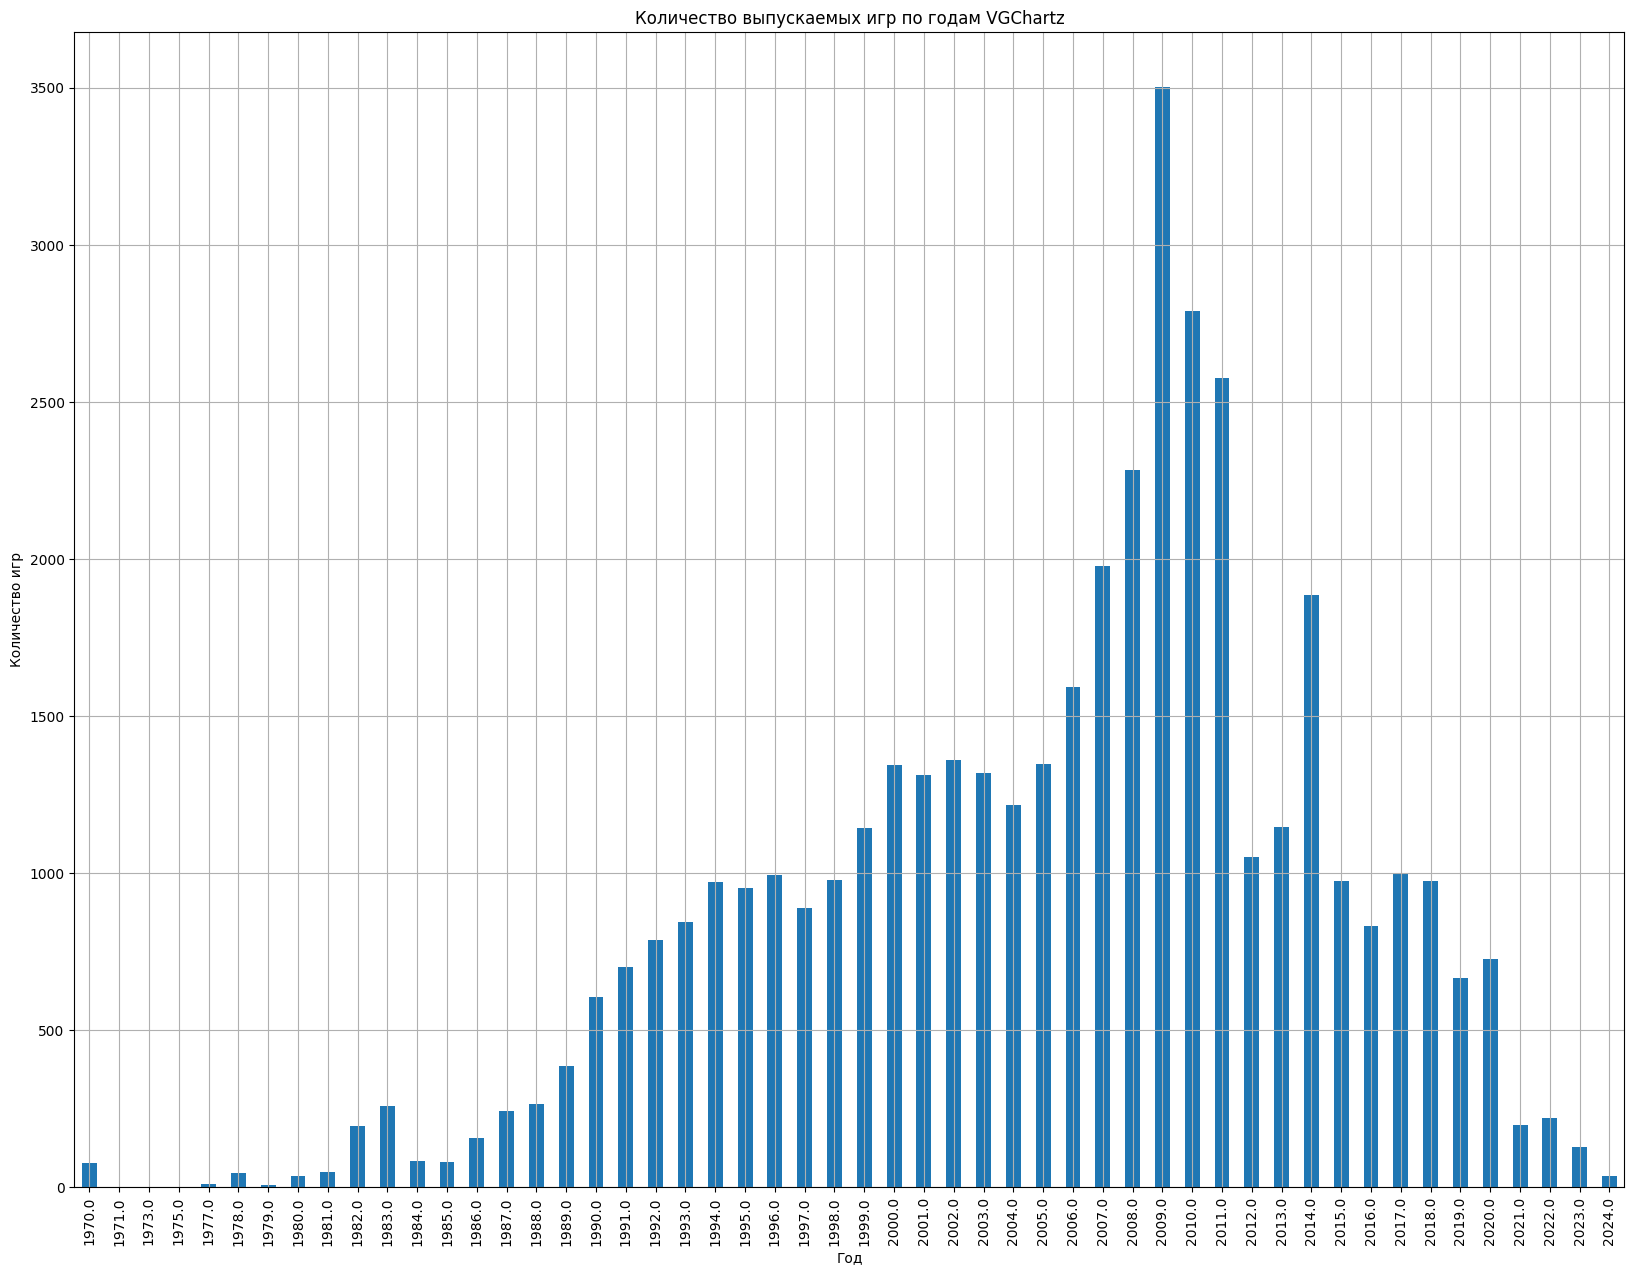

In [409]:
year_count2 = data_2.groupby('Year')['Year'].agg('count')
plt.figure(figsize = (20, 15))
graph_2 = year_count2.plot(title= "Количество выпускаемых игр по годам VGChartz", kind= "bar", grid= True)
plt.xlabel('Год')
plt.ylabel('Количество игр')

Как мы видим, сайт VGChartz начал сдавать свои позиции как одного из лучших информационных игровых сайтов, еще в 2021 - пик развития Стима, как мы и предполагали во введении. Также мы пожем константировать, что пиком развития игровой индустрии был 2009 год. Другой пик, который мы получили на данных стима был 2022. Между пиками прошло 13 лет, за это время индустрия игр серьезно изменилась, перейдя от пиксельных игр к высокотехнологичеким. 

Попробуем найти значимые корреляции в данных:

<Axes: >

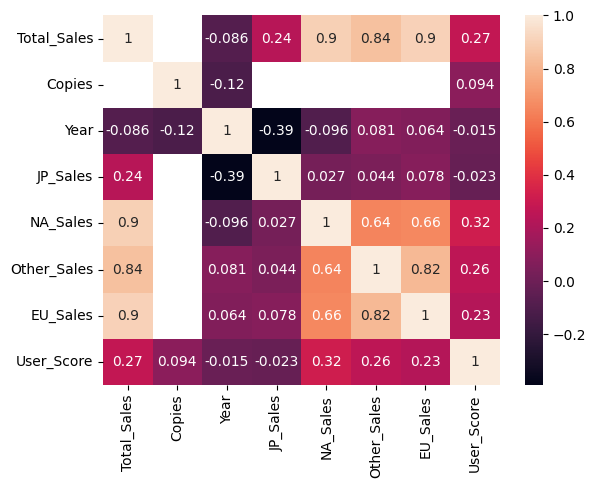

In [329]:
sea.heatmap(data_2.iloc[:,[1,2,4,6,7,8,9,10]].corr(), annot= True)

Кроме очевидной положительной корреляции между продажами, никакой другой значимой корреляции найти не удалось. 

В этом блоке мы нашли 5 самых популярных среди произодителей игр платформ в промежутке от 90 до 20ых годов (активное время работы сайта VGChartz). Не удивительно, что большинство игр разрабатывались под ПК, так как консоли контролировались большими корпорациями, а остальную долю рынка занимали более мелкие компании, которые не могли себе позволить разработку консолей. 

<Axes: xlabel='Console'>

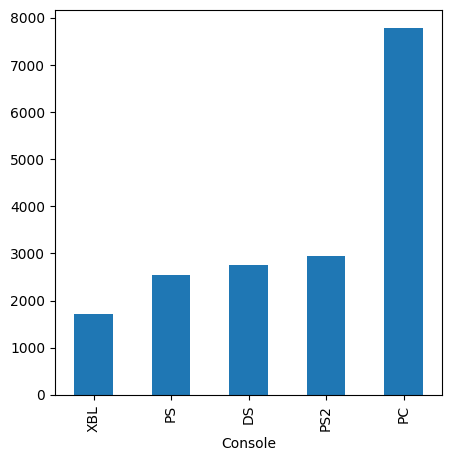

In [406]:
plt.figure(figsize = (5, 5))
best_console = list(data_2.groupby("Console")["Console"].agg("count").sort_values().tail().index)
data_2.groupby("Console")["Console"].agg("count").sort_values().tail().plot(kind= "bar")

Однако взгялянем на продажи - как мы видим, игры на консолях продавались больше всего, так как компьютеры были не у всех, позволить себе его мог не каждый, а консоли были очень удобными, с качественными инрыми от опытных разработчиков. Неудивительно, что лидером по продажам дого времени была именно PlayStation2 - самая популярная консоль в мире. 

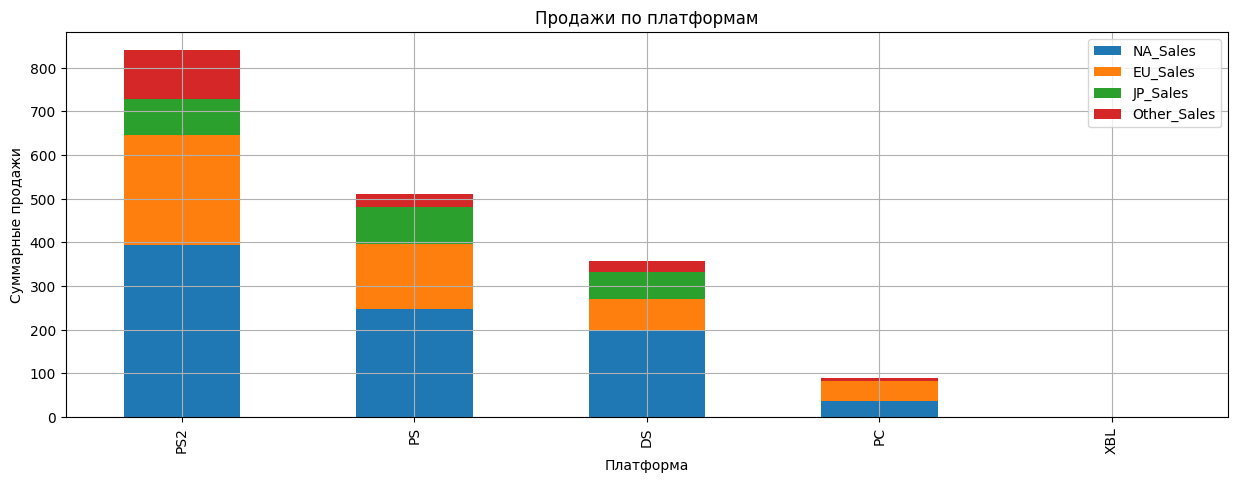

In [408]:
data_cut = data_2.query("Console in @best_console")
plot = data_cut.groupby("Console")[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].agg('sum').sort_values(by='EU_Sales',ascending=False).plot(kind='bar', title='Продажи по платформам', grid=True, figsize=(15, 5), stacked=True)
plot.set_xlabel('Платформа')
plot.set_ylabel('Суммарные продажи')
plt.show()

Отдельно можно отметить, что продажи выше всего были в Америке - стране производителе большинства игр и консолей.

# **Построение графа**

В этой теме мы построим двудольный граф, который связывает игру с языками, на которые она была переведена, таким образом, мы узнаем наиболее популярные языки в игровом мире. В коллекции по ключу (id) мы присваем список языков, доступных для этой игры. Также, формируем список уникльных языков и избавляемся от небольших ошибках в данных (из-за разной структуры ннкоторых стимовских игр). Далее, используя функции из документации, мы разбиваем вершины на две категории и строим связи между ними. Поскольку данных у нас огромное количество, мы рассмотрели slice исходного датафрейма. Можно менять в первой строке кода.

In [298]:
slice_of_data = data_1.loc[0:2000,:]

G = nt.Graph()
dict_lang = {}
unique_lang = []
ban_list = ["\\", "&", "(", ")", "/", ",", ";", "["]
id_count = 0
for item in slice_of_data["Supported languages"]:
    if type(item) is not float:
        dict_lang[id_count] = item
    else:
        continue
    for i in range(0, len(item)):
        if item[i] not in unique_lang and ban_list[1] not in item[i] and ban_list[5] not in item[i] and ban_list[7] not in item[i] and ban_list[6] not in item[i] and ban_list[0] not in item[i] and ban_list[2] not in item[i]:
            unique_lang.append(item[i])
        else:
            continue
    id_count += 1
G.add_nodes_from(list(dict_lang.keys()), bipartite= 1)
G.add_nodes_from(unique_lang, bipartite= 0)
for key,value in dict_lang.items():
    for item in unique_lang:
        if item in value:
            G.add_edge(item, key)
        else:
            continue


Визуализируем граф с помощью функций из matplotlib и networkx

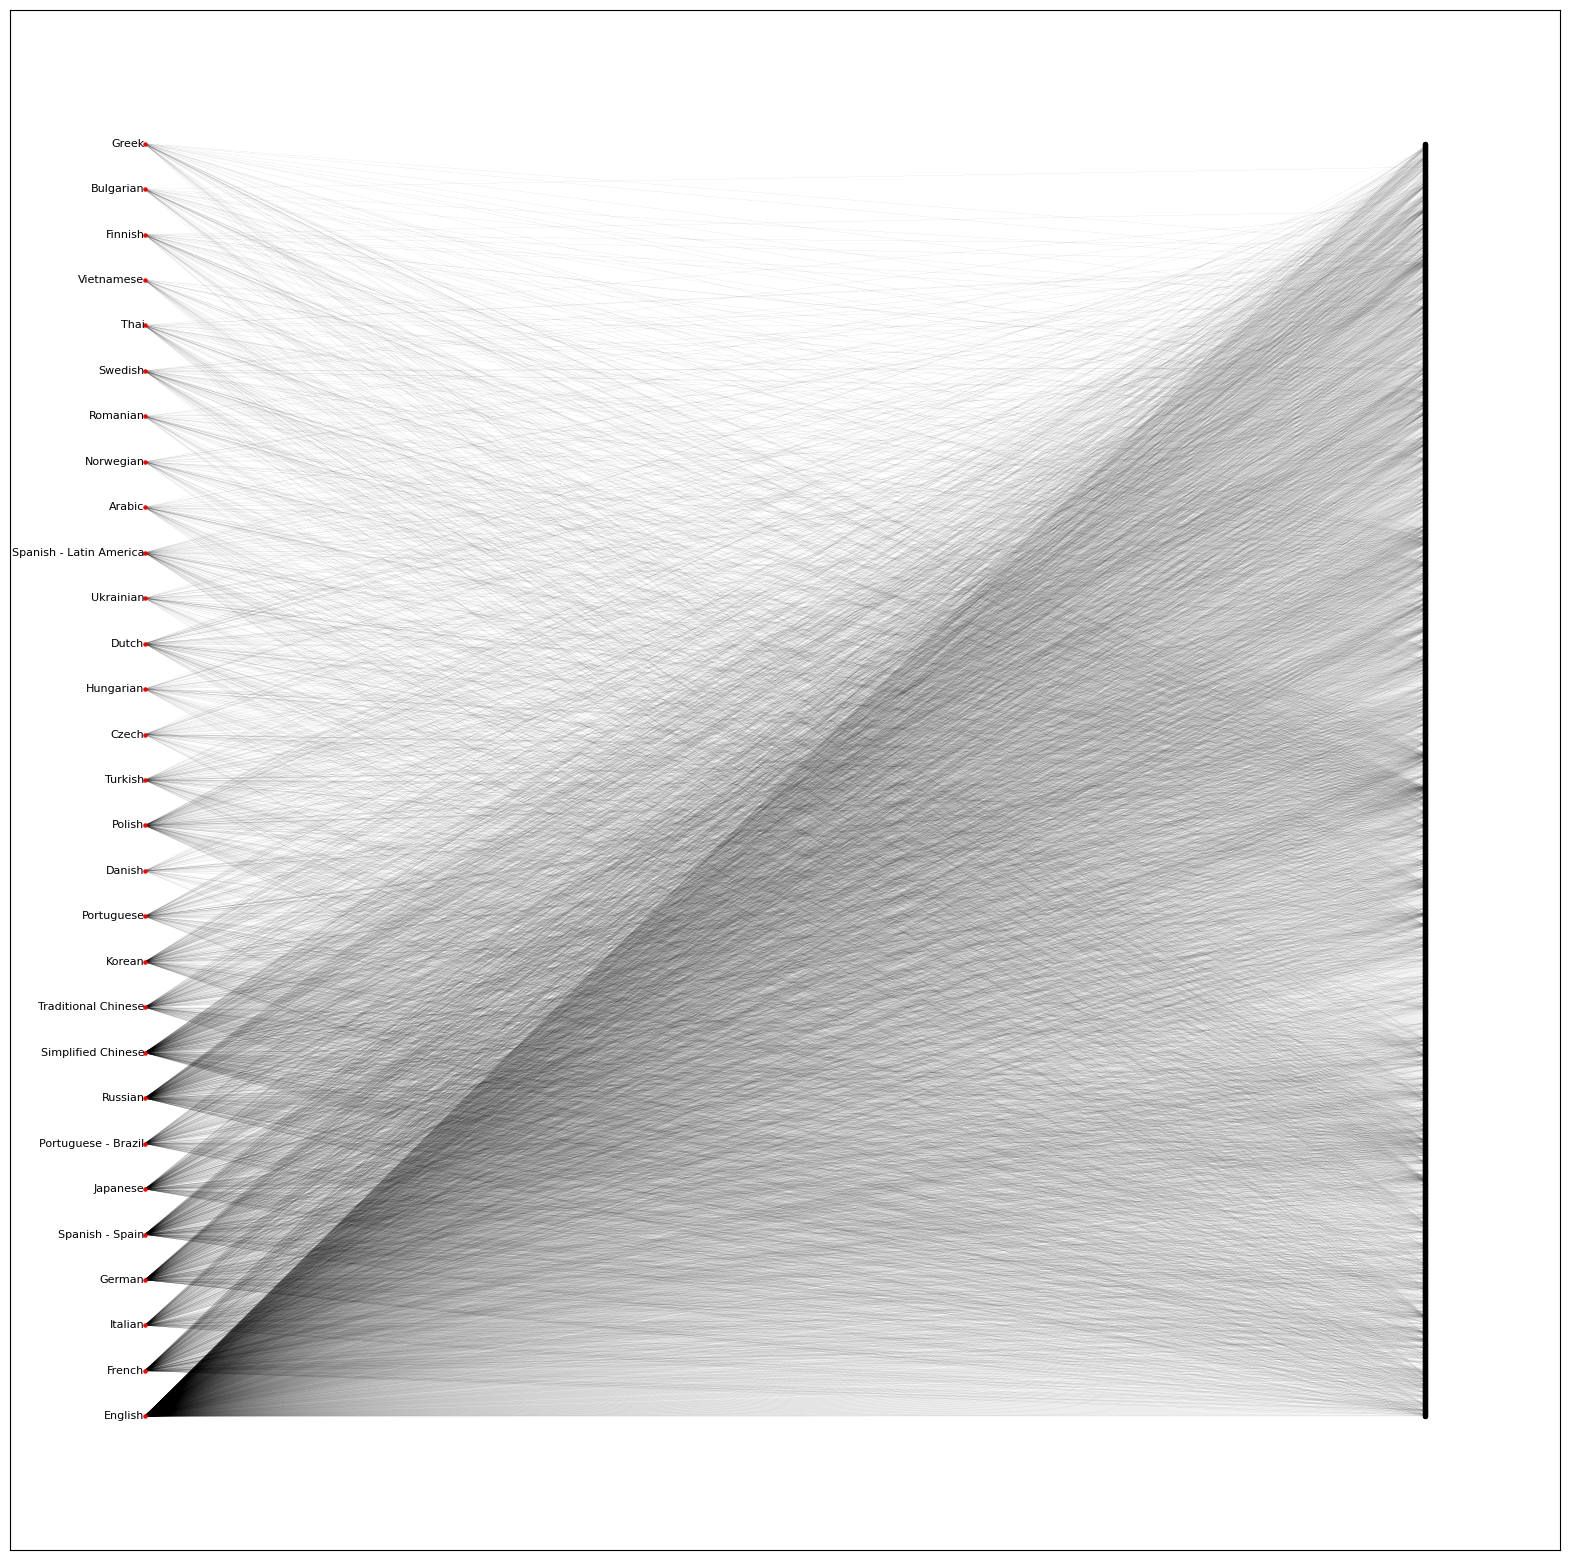

In [410]:
nodes_0 = [x for x in G.nodes if G.nodes[x]['bipartite'] == 0]
plt.figure(figsize = (20, 20))
layout = nt.bipartite_layout(G, nodes_0)
nt.draw_networkx_nodes(G, layout, nodelist= list(dict_lang.keys()), node_size = 8, node_color = 'black') 
nt.draw_networkx_nodes(G, layout, nodelist= unique_lang, node_size = 5, node_color = 'red')
nt.draw_networkx_labels(G, layout, labels= {n: n for n in unique_lang}, font_size = 8, horizontalalignment = 'right') 
nt.draw_networkx_edges(G, layout, node_size= 2, alpha=0.5, width= 0.05) 
plt.show()

Закономерно получили, что язык гейм индустрии - английский, чуть менее популярны европейские языки (Русский достаточно сильно поулярен среди других), также популярны японский и китайский - страна-производитель игр и страна с одним из самых больших населений в мире.

# **Выводы**

Касаемо гипотез, поставленных во введении:

1) VGChatz подходит для анализа только старых игр, Стим перехватил на себя роль хранилища игровой информации
2) Самая популярная консоль по данным с WGChartz будет PC
3) Между ценой игры в стиме и числом покупателей этой игры существует обратная связь


1 - потвердилась с опорой на соответствующие графики. Стим стал информационной гейминговой базой нашего времени.
2 - гипотеза подтвердилась, но с оговоркой, что популярна для разработчиков. Для обычных геймеров того времени самая популярная консоль - PS2, потом PS, что показали нам данные о продажах игр на этой консоли. 
3 - к большому удивлению, гипотеза была опровегнута отсутсвующей корреляцией. Можно принять альтернативную гипотезу, что для покупателей в Стиме цена не является определяющим фактором. Найти определяющий фактор не удалось, посольку высоких корреляций по цене не было.


Игровая индустрия очень интересна для исследования, но поскольку данные о ней либо платные, либо рассеяны по интернету, для бюджетных проектов тяжело делать какие-либо серьзные выводы. Например, одной из интересных тем было бы рассмотреть появление Nintendo Swith на рынке портативных консолей, ее вляиние на рынок, но эти данные найти чрезвычайно сложно. 

